**This notebook provide the best practices to consume covid-lake API.**

In [1]:
# General Import

import pandas as pd
import numpy as np
import re
import seaborn as sns

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline

#!pip install scipy
#from scipy.stats import pearsonr

In [2]:
# Plotting functions
#%run /home/ubuntu/notebooks/covid-prj01-data-analysis/[ANALISE-EXPLORATORIA]/python_plotting_functions.ipynb

In [3]:
#path = '"covid-raw".transparencia."breath_disease"."death_by_city_and_skin__2020.08.04.23.08.15.parquet"' # path from Dremio

# query = "SELECT * FROM {0};".format (path)
# query

In [4]:
%run /home/ubuntu/notebooks/covid-prj01-data-analysis/[UTILS]/dremio-access-new.py

dremio = DremioQueryMakerJDBC()
index = dremio.getRawIndex()
display(index)

# index é um dataframe, então é possível usar index.head(n) em que n é o número de linhas que você quer ver.

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,DREMIO,Covid-Lake,Disease_Indicator,VIEW
1,DREMIO,Covid-Lake,hospitalizações,VIEW
2,DREMIO,Covid-Lake,Institution,VIEW
3,DREMIO,Covid-Lake,News&Trends,VIEW
4,DREMIO,Covid-Lake,Socioeconomic_Factors,VIEW
...,...,...,...,...
199,DREMIO,covid-raw.ans.ftp.dadosabertos.ans.gov.br.FTP....,PEONA_2020.csv,TABLE
200,DREMIO,covid-raw.ans.ftp.dadosabertos.ans.gov.br.FTP....,PDA_Cobranca_e_Arrecadacao_SUS.csv,TABLE
201,DREMIO,covid-raw.ans.ftp.dadosabertos.ans.gov.br.FTP....,RPC_2015_1trim.csv,TABLE
202,DREMIO,covid-raw.ans.ftp.dadosabertos.ans.gov.br.FTP....,taxa_cobertura.csv,TABLE


In [5]:
df = dremio.getRawTable(19)
df.head()

,index,topic_title,derived_tstamp,geo_country,geo_region,geo_city,geo_zipcode,geo_latitude,geo_longitude,geo_region_name
0,0,Ivermectina pode ser usada como tratamento par...,2020-05-12,BR,PE,None,None,-8.0461,-34.9034,Pernambuco
1,1,Ivermectina pode ser usada como tratamento par...,2020-05-12,BR,MG,Ribeirão das Neves,33800,-19.7720,-44.0694,Minas Gerais
2,2,Ivermectina pode ser usada como tratamento par...,2020-05-12,BR,PE,Recife,50000,-8.0102,-34.9503,Pernambuco
3,3,Covid-19: FDA libera uso de cloroquina e hidro...,2020-05-12,BR,DF,Brasília,70640,-15.7792,-47.9341,Federal District
4,4,Ivermectina pode ser usada como tratamento par...,2020-05-12,BR,RJ,Rio de Janeiro,20000,-22.9201,-43.3307,Rio de Janeiro


In [6]:
df.dtypes

index                int64
topic_title         object
derived_tstamp      object
geo_country         object
geo_region          object
geo_city            object
geo_zipcode         object
geo_latitude       float64
geo_longitude      float64
geo_region_name     object
dtype: object

In [9]:
df.shape

(7804, 8)

### Let's play with Data :)

Checking all columns

In [10]:
all_columns = df.columns.values.tolist()
len(all_columns)
#all_columns

8

In [11]:
all_columns

['city',
 'UF',
 'skin_color',
 'disease',
 '2020',
 '2019',
 'created_at',
 '__index_level_0__']

Verifying all NAs

In [12]:
# count NAs per column
#df.isnull().sum()
df.isna().sum()

city                    0
UF                      0
skin_color              0
disease                 0
2020                 2634
2019                 3071
created_at              0
__index_level_0__       0
dtype: int64

Dropping all NAs

In [13]:
# shows all NAs
#df.isna()

# remove columns full of NAs
df = df.dropna(axis=1,how='all')
df.head()

,city,UF,skin_color,disease,2020,2019,created_at,__index_level_0__
0,São Paulo,SP,AMARELA,OUTRAS,27.0,35.0,04-08-2020 19:28,0
1,São Paulo,SP,AMARELA,COVID,1.0,NaN,04-08-2020 19:28,1
2,São Paulo,SP,AMARELA,INDETERMINADA,1.0,2.0,04-08-2020 19:28,2
3,São Paulo,SP,AMARELA,PNEUMONIA,2.0,5.0,04-08-2020 19:28,3
4,São Paulo,SP,AMARELA,SRAG,2.0,NaN,04-08-2020 19:28,4


In [14]:
df.shape

(7804, 8)

Verifying the duplicated columns

In [15]:
# drop duplicates
df = df.drop_duplicates() 
df.head()
# no duplicates

,city,UF,skin_color,disease,2020,2019,created_at,__index_level_0__
0,São Paulo,SP,AMARELA,OUTRAS,27.0,35.0,04-08-2020 19:28,0
1,São Paulo,SP,AMARELA,COVID,1.0,NaN,04-08-2020 19:28,1
2,São Paulo,SP,AMARELA,INDETERMINADA,1.0,2.0,04-08-2020 19:28,2
3,São Paulo,SP,AMARELA,PNEUMONIA,2.0,5.0,04-08-2020 19:28,3
4,São Paulo,SP,AMARELA,SRAG,2.0,NaN,04-08-2020 19:28,4


In [16]:
df.shape

(7804, 8)

Shows all the data, though it runs quite slow for big datasets

In [17]:
#force_show_all_columns(df)

Describe the dataset

In [18]:
df.describe()

,2020,2019,__index_level_0__
count,5170.000000,4733.000000,7804.000000
mean,4.150097,4.222480,0.677858
std,24.140178,24.877853,1.133198
min,1.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000
75%,3.000000,3.000000,1.000000
max,1218.000000,1241.000000,6.000000


Describe the fields

In [24]:
df[NOME_COLUNA].describe()

count          7804
unique         2926
top       São Paulo
freq             28
Name: city, dtype: object

In [25]:
df[NOME_COLUNA].unique()


array(['São Paulo', 'São Bernardo do Campo', 'Sumare', ...,
       'Abel Figueiredo', 'Santa Carmem', 'Pombos'], dtype=object)

In [27]:
# array with each count    
counts = np.unique(df[NOME_COLUNA], return_counts=True)

# dataframe
df_count = pd.DataFrame({NOME_COLUNA: counts[0], 'freq': counts[1]})
df_count.sort_values(by=['freq'], inplace=True,ascending=False)
df_count.head()

,UF,freq
25,SP,1385
10,MG,990
5,CE,583
22,RS,511
8,GO,458


In [28]:
df_count.tail()

,UF,freq
2,AM,50
6,DF,47
0,AC,47
3,AP,28
21,RR,12


## Graphs

#### Showing the null values

In [33]:
df

,city,UF,skin_color,disease,2020,2019,created_at,__index_level_0__
0,São Paulo,SP,AMARELA,OUTRAS,27.0,35.0,04-08-2020 19:28,0
1,São Paulo,SP,AMARELA,COVID,1.0,NaN,04-08-2020 19:28,1
2,São Paulo,SP,AMARELA,INDETERMINADA,1.0,2.0,04-08-2020 19:28,2
3,São Paulo,SP,AMARELA,PNEUMONIA,2.0,5.0,04-08-2020 19:28,3
4,São Paulo,SP,AMARELA,SRAG,2.0,NaN,04-08-2020 19:28,4
...,...,...,...,...,...,...,...,...
7799,Santa Carmem,MT,BRANCA,OUTRAS,2.0,NaN,04-08-2020 20:52,0
7800,Cachoeirinha,PE,PARDA,OUTRAS,1.0,2.0,04-08-2020 20:52,0
7801,Cachoeirinha,PE,PRETA,OUTRAS,NaN,1.0,04-08-2020 20:52,0
7802,Pombos,PE,BRANCA,OUTRAS,NaN,1.0,04-08-2020 20:52,0


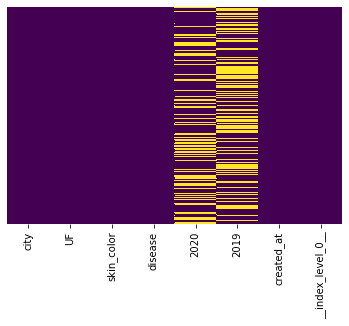

In [34]:
# Missing values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [35]:
# For more details
display(df.isnull().sum().sort_values(ascending=False))

2019                 3071
2020                 2634
__index_level_0__       0
created_at              0
disease                 0
skin_color              0
UF                      0
city                    0
dtype: int64

#### Looking for correlations

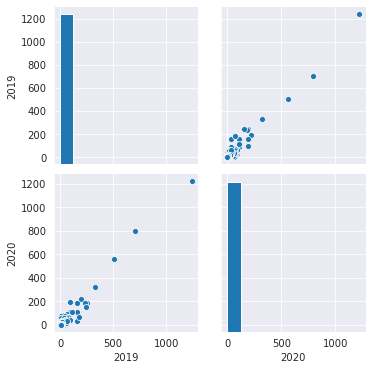

In [37]:
columns = [
    '2019',	 
    '2020'
]
sns.set_style("darkgrid")
sns.pairplot(df[columns])

### LET'S CHECK SOME CORRELATION. Let's verify that:

In [32]:
#from scipy.stats import personsr
# pearson_cor = pearsonr(df.deaths, df.confirmed)
# print('Pearsons correlation: %.3f' % pearson_cor[0])

Pearsons correlation: 0.973


#### EXAMPLE
#### This hypothesis was confirmed, with a very high correlation: 0.973

### Unifying the date column to produce more graphs

In [33]:
# # Unify the date column format
# df['date'] = pd.to_datetime(df.date).dt.date
# # Sort dates
# df = df.sort_values('date')
# df = df.dropna(subset=['city'])
# df = df.loc[df.place_type == 'city']
# cumulated = df.groupby('date').agg({'confirmed': 'sum', 
#                                     'deaths': 'sum', 
#                                     'confirmed_per_100k_inhabitants': 'sum'}).reset_index()

In [34]:
# cumulated.head()

,date,confirmed,deaths,confirmed_per_100k_inhabitants
0,2020-02-25,1,0,0.00816
1,2020-02-26,1,0,0.00816
2,2020-02-27,1,0,0.00816
3,2020-02-28,2,0,0.01632
4,2020-02-29,2,0,0.01632


In [35]:
# cumulated.describe()

,confirmed,deaths,confirmed_per_100k_inhabitants
count,98.000000,98.000000,98.000000
mean,71221.010204,4594.326531,66932.596135
std,106976.683775,6683.073959,126713.585296
min,1.000000,0.000000,0.008160
25%,719.000000,3.250000,229.970297
50%,22755.000000,1285.000000,10444.265615
75%,93779.750000,6618.750000,60589.375808
max,460001.000000,27062.000000,559448.858040


 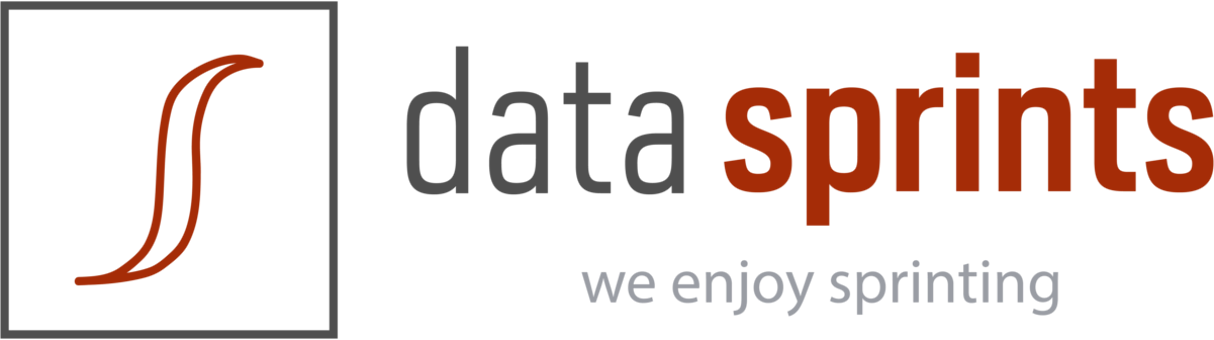